Importare le librerie


In [2]:
!pip install timm

# --- Inizio Codice ResNet101V2 con Augmentation ---

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import timm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive
from PIL import Image

# Montare Google Drive
drive.mount('/content/drive')

# Configurazione del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilizzato: {device}")

Mounted at /content/drive
Device utilizzato: cuda


Caricare i dati

In [3]:
# Percorsi ai dati
train_dir = '/content/drive/MyDrive/Night_Wolves/RPvsControl/data/train'
test_dir  = '/content/drive/MyDrive/Night_Wolves/RPvsControl/data/test'

# Definizione delle trasformazioni
common_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

augmentation_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Classe personalizzata per aumentare la classe minoritaria
class AugmentedImageFolder(torch.utils.data.Dataset):
    def __init__(self, root, common_transform, augmentation_transform, minority_class=1, replicate_factor=4):
        """
        root: percorso della directory
        common_transform: trasformazione comune a tutte le immagini
        augmentation_transform: trasformazione aggiuntiva per le immagini della classe minoritaria
        minority_class: label della classe da aumentare (es. 1 per "Retinite Pigmentosa")
        replicate_factor: quante volte replicare le immagini minoritarie
        """
        self.dataset = ImageFolder(root, transform=common_transform)
        self.common_transform = common_transform
        self.augmentation_transform = augmentation_transform
        self.minority_class = minority_class

        # Separazione degli indici per le classi
        self.control_indices = [i for i, (_, label) in enumerate(self.dataset.samples) if label != self.minority_class]
        self.minority_indices = [i for i, (_, label) in enumerate(self.dataset.samples) if label == self.minority_class]
        # Replica le immagini della classe minoritaria
        self.rep_minority_indices = self.minority_indices * replicate_factor

        # Combinazione degli indici per creare il dataset bilanciato
        self.total_indices = self.control_indices + self.rep_minority_indices

    def __len__(self):
        return len(self.total_indices)

    def __getitem__(self, idx):
        real_idx = self.total_indices[idx]
        path, label = self.dataset.samples[real_idx]
        image = Image.open(path).convert('RGB')
        if label == self.minority_class:
            img = self.augmentation_transform(image)
        else:
            img = self.common_transform(image)
        return img, label

# Creazione del dataset di training bilanciato e del test set
full_train_data = AugmentedImageFolder(train_dir, common_transform, augmentation_transform, minority_class=1, replicate_factor=4)
test_data = ImageFolder(test_dir, transform=common_transform)
print(f"Training dataset bilanciato: {len(full_train_data)} immagini")
print(f"Test dataset: {len(test_data)} immagini")

# Split train/validation (80/20)
val_size = int(0.2 * len(full_train_data))
train_size = len(full_train_data) - val_size

# DataLoader per il test set (fisso)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

Training dataset bilanciato: 1632 immagini
Test dataset: 258 immagini


# Creazione del modello ResNet101V2 (usando resnetv2_101 da timm)

In [4]:
# Creazione del modello ResNet101V2 (num_classes=1 per classificazione binaria)
model = timm.create_model("resnetv2_101", pretrained=True, num_classes=1)
model.to(device)
print(model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

ResNetV2(
  (stem): Sequential(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (stages): Sequential(
    (0): ResNetStage(
      (blocks): Sequential(
        (0): PreActBottleneck(
          (downsample): DownsampleConv(
            (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm): Identity()
          )
          (norm1): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv2): Conv2d(64, 64, kernel_size=

# Funzione di perdita e ottimizzazione

In [5]:
# Loss, ottimizzatore, scheduler
criterion = nn.BCEWithLogitsLoss()  # Combina Sigmoid + BCELoss
optimizer = optim.Adam(model.parameters(), lr=0.001) # Learning rate iniziale
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


# Addestrare il modello

Epoch 1/20 | Train Loss: 0.2720, Acc: 0.9387 | Val Loss: 0.0183, Acc: 0.9939
Epoch 2/20 | Train Loss: 0.0602, Acc: 0.9786 | Val Loss: 0.0313, Acc: 0.9908
Epoch 3/20 | Train Loss: 0.0425, Acc: 0.9839 | Val Loss: 0.0395, Acc: 0.9877
Epoch 4/20 | Train Loss: 0.0162, Acc: 0.9939 | Val Loss: 0.0550, Acc: 0.9663
Epoch 5/20 | Train Loss: 0.0218, Acc: 0.9931 | Val Loss: 0.0340, Acc: 0.9877
Epoch 6/20 | Train Loss: 0.0181, Acc: 0.9969 | Val Loss: 0.0329, Acc: 0.9939
Early stopping triggered.


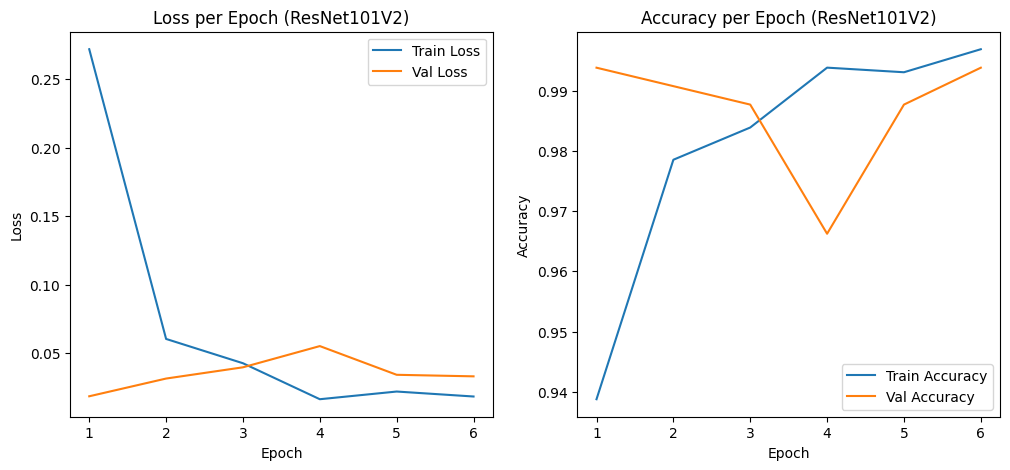

In [6]:
# Variabili per il tracciamento
num_epochs = 20
train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_val_loss = float('inf')
patience, trigger_times = 5, 0

# Ciclo di addestramento con random split ad ogni epoca
for epoch in range(num_epochs):
    # Nuovo split random per ogni epoca
    train_subset, val_subset = random_split(full_train_data, [train_size, val_size])
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_subset, batch_size=32, shuffle=True)

    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / total_train
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validazione
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / total_val
    val_acc = correct_val / total_val
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'resnet101v2_best.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

# Grafici di addestramento
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch (ResNet101V2)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, train_accs, label='Train Accuracy')
plt.plot(epochs_range, val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch (ResNet101V2)')
plt.legend()
plt.show()


# Valutazione del modello

In [7]:
# Funzione per valutare il modello sui dati di test
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy}%")

evaluate(model, test_loader)


Accuracy: 89.14728682170542%


# Matrice di confusione

Confusion Matrix:
[[209   0]
 [ 28  21]]


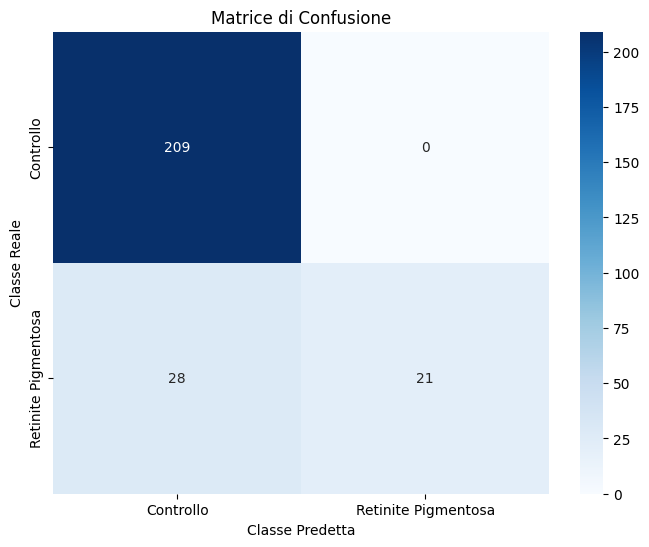

Classification Report:
                     precision    recall  f1-score   support

          Controllo       0.88      1.00      0.94       209
Retinite Pigmentosa       1.00      0.43      0.60        49

           accuracy                           0.89       258
          macro avg       0.94      0.71      0.77       258
       weighted avg       0.90      0.89      0.87       258



In [8]:
# Funzione per calcolare e visualizzare la matrice di confusione
def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).float()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Matrice di Confusione')
    plt.xlabel('Classe Predetta')
    plt.ylabel('Classe Reale')
    plt.show()

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Definizione delle classi
class_names = ['Controllo', 'Retinite Pigmentosa']
plot_confusion_matrix(model, test_loader, class_names)

Utilizzare il modello

In [ ]:
# Funzione per fare una previsione su una singola immagine
def predict_image(model, image_path):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        prediction = (torch.sigmoid(output.squeeze()) > 0.5).float()

    print(f"Predizione: {'Retinite Pigmentosa' if prediction == 1 else 'Controllo'}")

# Esecuzione di una previsione su una immagine di test
img_path = '/content/drive/MyDrive/Night_Wolves/RPvsControl/data/test/retinite/Retinitis Pigmentosa73.jpg'
predict_image(model, img_path)

Predizione: Controllo
